In [1]:
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install spotipy --upgrade

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline

# 1. Preparación de los datos

**Datos a nivel de Canciones**

In [5]:
#Dataset de canciones y distintos datos relacionados
spotify_df = pd.read_csv('data.csv')
spotify_df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


**Datos a nivel de Artistas y Géneros relacionados**

In [6]:
#Dataset de artistas y generos correspondientes
data_w_genre = pd.read_csv('data_w_genres.csv')
data_w_genre.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.598500,0.470100,267072.000000,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000,5,1,10,['show tunes']
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,31.538462,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.571429,0,1,7,[]
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.407407,0,1,27,[]
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,42.000000,5,1,7,[]


In [7]:
#data_w_genre.dtypes

In [8]:
#Chequeamos estructura de los valores en la columna del género
data_w_genre['genres'].values

array(["['show tunes']", '[]', '[]', ..., '[]', '[]',
       "['classic korean pop']"], dtype=object)

In [9]:
data_w_genre['genres'].values[0]

"['show tunes']"

In [10]:
data_w_genre['genres'].values[0][0]

'['

Los valores asociados a la campo 'genres' se encuentran en formato string.

Para poder acceder de forma más sencilla (desde un formato lista) a los datos de dicho campo aplicamos una expresión regular que extraiga los distintos valores de los géneros y sean insertados en el dataset original a través de una  nueva columna "genres_upd".

In [11]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [12]:
#Verificamos paso anterior y efectivamente obtenemos en la columna generos el formato deseado
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

A continuación aplicamos los mismos pasos al dataset "data.csv" pero en este caso extrayendo información de los Artistas que se encuentran a través del campo "artists".

In [13]:
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))

In [14]:
#Chequeamos estructura de los valores en la columna de artista
spotify_df['artists'].values

array(["['Mamie Smith']", '["Screamin\' Jay Hawkins"]', "['Mamie Smith']",
       ..., "['Roger Fly']", "['Taylor Swift']", "['Roger Fly']"],
      dtype=object)

In [15]:
spotify_df['artists'].values[0]

"['Mamie Smith']"

In [16]:
spotify_df['artists'].values[0][0]

'['

In [17]:
#Verificamos paso anterior 
spotify_df['artists_upd_v1'].values[0][0]

'Mamie Smith'

In [18]:
#Volvemos a verificar pero para un conjunto mayor de artistas
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(10)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1
1,0.643,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.950,1920,[]
34,0.021,"[""The Swingin' Bachelors""]",0.559,288293,0.830,0,0bq1lNI8OPhdRQYZZSSnQk,0.146000,11,0.1870,-7.876,0,Voodoo Doll,0,1920-02-29,0.0546,107.912,0.352,1920,[]
36,0.790,"[""The Swingin' Bachelors""]",0.745,261013,0.791,0,0e0zhCKclqwgJgA7Tjg2ca,0.000000,7,0.1020,-8.584,1,Penticton Kitty,0,1920-02-29,0.0595,120.169,0.658,1920,[]
46,0.147,"[""The Swingin' Bachelors""]",0.603,235547,0.719,0,0xKe1lGyWBuk3lx3JIUUUx,0.000000,0,0.1110,-5.464,0,Cloud 9,0,1920-02-29,0.0271,92.010,0.697,1920,[]
47,0.367,"[""The Swingin' Bachelors""]",0.716,264240,0.836,0,11rj3RWlVnnxW0EL7jwN8R,0.000006,9,0.1910,-6.099,1,Big Jim and the Twins,0,1920-02-29,0.0451,105.986,0.635,1920,[]
58,0.730,"[""The Swingin' Bachelors""]",0.720,210293,0.718,0,1Gt8Mf423GHyuXIRHM1ymX,0.000003,0,0.3190,-7.470,1,Jitterbug Jive,0,1920-02-29,0.0336,125.006,0.885,1920,[]
70,0.520,"[""The Swingin' Bachelors""]",0.707,279053,0.324,0,1spKxUCvNzw1ZmZLPotE1k,0.000558,5,0.1930,-10.098,1,Beat Up Scratched Up,0,1920-02-29,0.0253,103.933,0.527,1920,[]
77,0.229,"[""The Swingin' Bachelors""]",0.747,269360,0.708,0,23AaYEj5iOKOIzfnzbA6Nu,0.000000,9,0.1360,-5.827,1,Gold Digger,0,1920-02-29,0.0297,111.868,0.635,1920,[]
166,0.428,"[""The Swingin' Bachelors""]",0.797,158747,0.683,0,4yQu4WbamHMMBuAg3z8qy2,0.000017,2,0.2800,-6.893,1,Ambisextrous,0,1920-02-29,0.0345,116.050,0.832,1920,[]
184,0.903,"[""The Swingin' Bachelors""]",0.611,237653,0.377,0,5MPqeFSuX4PRAwJ4qKeAZL,0.000007,7,0.2520,-9.694,1,Honeymoon in Niagara Falls,0,1920-02-29,0.0291,87.971,0.464,1920,[]


*Se observa para la muestra tomada que no se aplicó correctamente dicha extracción de valores para todos los artistas al tener conjuntos vacíos en la última columna creada.

Se aplica una nueva expresión regular:

In [19]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [20]:
#Volvemos a verificar y se corroborrá efecticamente en las últimas columnas 'artists_upd_v2' y 'artists_upd'
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,name,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd
1,0.643,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,...,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.950,1920,[],[Screamin' Jay Hawkins],[Screamin' Jay Hawkins]
34,0.021,"[""The Swingin' Bachelors""]",0.559,288293,0.830,0,0bq1lNI8OPhdRQYZZSSnQk,0.146000,11,0.1870,...,Voodoo Doll,0,1920-02-29,0.0546,107.912,0.352,1920,[],[The Swingin' Bachelors],[The Swingin' Bachelors]
36,0.790,"[""The Swingin' Bachelors""]",0.745,261013,0.791,0,0e0zhCKclqwgJgA7Tjg2ca,0.000000,7,0.1020,...,Penticton Kitty,0,1920-02-29,0.0595,120.169,0.658,1920,[],[The Swingin' Bachelors],[The Swingin' Bachelors]
46,0.147,"[""The Swingin' Bachelors""]",0.603,235547,0.719,0,0xKe1lGyWBuk3lx3JIUUUx,0.000000,0,0.1110,...,Cloud 9,0,1920-02-29,0.0271,92.010,0.697,1920,[],[The Swingin' Bachelors],[The Swingin' Bachelors]
47,0.367,"[""The Swingin' Bachelors""]",0.716,264240,0.836,0,11rj3RWlVnnxW0EL7jwN8R,0.000006,9,0.1910,...,Big Jim and the Twins,0,1920-02-29,0.0451,105.986,0.635,1920,[],[The Swingin' Bachelors],[The Swingin' Bachelors]


A continuación se observa otro inconveniente en el dataset: para una misma canción se tienen id's distintos y por lo tanto se tienen canciones duplicadas.



In [21]:
#Ejemplo:
spotify_df[spotify_df['name']=='Hello']

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,name,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd
12512,0.4140,['Lionel Richie'],0.487,251107,0.246,0,0mHyWYXmmCB9iQyK18m3FQ,0.000000,9,0.0983,...,Hello,57,1983-01-01,0.0376,61.084,0.0562,1983,[Lionel Richie],[],[Lionel Richie]
38280,0.3300,['Adele'],0.578,295502,0.430,0,62PaSfnXSMyLshYJrlTuL3,0.000000,5,0.0854,...,Hello,71,2015-11-20,0.0305,78.991,0.2880,2015,[Adele],[],[Adele]
51034,0.5160,['Lionel Richie'],0.563,248573,0.262,0,1b16zIZIdL2LIMfDiANwIk,0.000000,9,0.1940,...,Hello,42,1983,0.0333,124.206,0.0626,1983,[Lionel Richie],[],[Lionel Richie]
54384,0.1550,"['Ice Cube', 'Dr. Dre', 'MC Ren']",0.903,232533,0.610,1,60uesDF4UyLUs61FgiDkdp,0.000000,10,0.3890,...,Hello,58,2000-02-29,0.3390,91.460,0.6270,2000,"[Ice Cube, Dr. Dre, MC Ren]",[],"[Ice Cube, Dr. Dre, MC Ren]"
71560,0.0136,['Oasis'],0.318,203187,0.952,0,4qYlBtzkmby4r1N7etPnUv,0.015200,9,0.1670,...,Hello,55,1995-10-02,0.0940,132.191,0.0537,1995,[Oasis],[],[Oasis]
73174,0.9120,['Evanescence'],0.416,220360,0.178,0,0aYUqsvZG7bAslrUkd9Z0g,0.000138,11,0.3420,...,Hello,58,2003-03-04,0.0310,139.969,0.0699,2003,[Evanescence],[],[Evanescence]
76768,0.4650,"['KAROL G', 'Ozuna']",0.802,194933,0.839,0,2776pPgCa5KrLVUqNBtjfJ,0.000052,7,0.1170,...,Hello,0,2021-01-22,0.0592,94.997,0.8610,2021,"[KAROL G, Ozuna]",[],"[KAROL G, Ozuna]"
76774,0.4650,"['KAROL G', 'Ozuna']",0.802,194933,0.839,0,2ljhKzXJAPBmRN0QIkxKHG,0.000052,7,0.1170,...,Hello,0,2021-01-22,0.0592,94.997,0.8610,2021,"[KAROL G, Ozuna]",[],"[KAROL G, Ozuna]"
76780,0.4650,"['KAROL G', 'Ozuna']",0.802,194933,0.839,0,36YVsPZh2byKbodjUDyjTG,0.000052,7,0.1170,...,Hello,0,2021-01-22,0.0592,94.997,0.8610,2021,"[KAROL G, Ozuna]",[],"[KAROL G, Ozuna]"
76782,0.4650,"['KAROL G', 'Ozuna']",0.802,194933,0.839,0,371SS9OeuFXXUvF3SECivH,0.000052,7,0.1170,...,Hello,0,2021-01-22,0.0592,94.997,0.8610,2021,"[KAROL G, Ozuna]",[],"[KAROL G, Ozuna]"


Solución: 

*   Se crea un identificador propio para todas las canciones, concatenando "artista+canción", en una nueva columna "artists_song".
*   Se eliminan las filas correspondientes a canciones repetidas, es decir con mismo "artista+canción", dejando exclusivamente a la canción con fecha de lanzamiento más reciente.



In [22]:
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [23]:
#Ordenamos los valores por fecha de lanzamiento
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [24]:
#Se eliminan la canciones repetidas y se mantiene aquella con mayor valor en "release_date"
spotify_df.drop_duplicates('artists_song',inplace = True)

In [116]:
#Verificamos
spotify_df[spotify_df['name']=='Boi soberano'].head(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red
14406,0.821,['Tião Carreiro & Pardinho'],0.716,197720,0.171,0,2P5mqpbcyDtAYrWTbF9xjg,0.0,10,0.0774,...,0.229,113.308,0.367,1966,[Tião Carreiro & Pardinho],[],[Tião Carreiro & Pardinho],Tião Carreiro & PardinhoBoi soberano,"[sertanejo_tradicional, sertanejo, sertanejo_u...",10


Luego realizamos una depuración de los datos y nos quedamos con una versión más limpia del dataset combinando los valores de artistas obtenidos en la columna "artists_upd" y manteniendo las columnas "genres" y "genres_upd" para los géneros correspondientes.

In [26]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')


In [27]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [28]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='4qYlBtzkmby4r1N7etPnUv']

,artists_upd,id,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres,genres_upd
71771,Oasis,4qYlBtzkmby4r1N7etPnUv,Oasis,0.103121,0.305854,284864.189189,0.82027,0.126644,0.296551,-4.309432,0.055005,126.92127,0.274241,55.135135,9.0,1.0,74.0,"['beatlesque', 'britpop', 'madchester', 'perma...","[beatlesque, britpop, madchester, permanent_wa..."


Finalmente, realizaremos dos últimos pasos más para concluir nuestra preparación de los datos:


1.   Agruparemos las canciones por su id junto a sus géneros obtenidos en "genres_upd" en una lista de listas.
2.   Obtendremos en una nueva columna todos los generos asociados a la canción en un formato de lista única.



In [29]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [30]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [31]:
artists_genres_consolidated.head()

,id,genres_upd,consolidates_genre_lists
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_wave, new_wave_po...","[candy_pop, permanent_wave, dance_rock, new_wa..."
1,000Npgk5e2SgwGaIsN3ztv,"[[classic_bollywood, classic_pakistani_pop, fi...","[classic_pakistani_pop, classic_bollywood, fil..."
2,000ZxLGm7jDlWCHtcXSeBe,"[[boogie-woogie, piano_blues, stride]]","[piano_blues, boogie-woogie, stride]"
3,000jBcNljWTnyjB4YO7ojf,[[bomba_y_plena]],[bomba_y_plena]
4,000mGrJNc2GAgQdMESdgEc,"[[classical, french_romanticism, late_romantic...","[french_romanticism, late_romantic_era, classi..."


In [32]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

# 2. Feature Engineering (Content base algorithm)



- Normalize float variables
- One-Hot-Encode: Year and Popularity Variables
- Create TF-IDF features off of artist genres

In [33]:
#Dataset a nivel de canciones y artistas tras preparación de los datos 
spotify_df.tail(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists
158279,0.0248,"[""Lil' Flip"", 'Lea']",0.814,225173,0.3870,1,4s0o8TJHfX9LLHa0umnOzT,0.000000,0,0.131,...,2004-03-30,0.0945,93.961,0.792,2004,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)",NaN
158280,0.0249,"[""World Class Wreckin' Cru"", ""Michel 'Le""]",0.715,351040,0.4900,0,3hoiinUc5VA9xUEJID7R8V,0.000170,9,0.139,...,1994-04-06,0.0479,129.309,0.429,1994,"[ Cru"", ""Michel ]","[World Class Wreckin' Cru, Michel 'Le]","[ Cru"", ""Michel ]","Cru"", ""Michel Turn Off The Lights - Rap",NaN
158281,0.9940,"[""Vienna Boys' Choir"", 'Uwe Christian Harrer']",0.317,98000,0.0543,0,7GaUNnAdIMXrvYG7673QIK,0.027700,10,0.168,...,1996-01-01,0.0777,81.111,0.290,1996,"[ Choir"", ]",[Vienna Boys' Choir],"[ Choir"", ]","Choir"", O Tannenbaum",NaN
158282,0.0421,"[""Rappin' 4-Tay"", 'Herm']",0.893,232267,0.5770,0,0CHKRuAjf8LvCL6SxCnq7V,0.000177,7,0.119,...,1999-09-17,0.1850,93.000,0.572,1999,"[ 4-Tay"", ]",[Rappin' 4-Tay],"[ 4-Tay"", ]","4-Tay"", Playa of the Year",NaN
158283,0.0113,"[""Rappin' 4-Tay"", 'MC Breed', 'Too $hort']",0.897,337973,0.4140,1,78859Af0fmA9VTlgnOHTAP,0.000110,4,0.101,...,1996,0.2460,96.039,0.273,1996,"[ 4-Tay"", , , ]",[Rappin' 4-Tay],"[ 4-Tay"", , , ]","4-Tay"", Never Talk Down",NaN


In [34]:
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [35]:
#Normalización valores float para que datos se encuentren en una misma escala
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [36]:
#One-hot encoding sobre columna "popularity"
ohe_cols = 'popularity'

#https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

In [37]:
spotify_df['popularity'].describe()

count    158284.000000
mean         25.765175
std          21.732005
min           0.000000
25%           1.000000
50%          26.000000
75%          42.000000
max         100.000000
Name: popularity, dtype: float64

In [38]:
# create 5 point buckets for popularity 
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [39]:
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [40]:
spotify_df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red
0,0.568,['조정현'],0.447,237688,0.215,0,2ghebdwe2pNXT4eL34T7pW,0.000001,10,0.0649,...,0.0272,71.979,0.1770,1989,[조정현],[],[조정현],조정현그아픔까지사랑한거야,[classic_korean_pop],6
1,0.939,"['김효근', 'Quinever 퀸에버']",0.174,341821,0.321,0,6ra76urfo3pTD050opXTZS,0.756000,3,0.6950,...,0.0422,138.300,0.0554,2019,"[김효근, Quinever 퀸에버]",[],"[김효근, Quinever 퀸에버]",김효근Promise of Thousand Years 천 년의 약속,[],0
2,0.509,['김수철'],0.456,189245,0.321,0,4FG1uHQAVPsYiXIn3tcGRs,0.000001,4,0.1560,...,0.0314,79.114,0.2100,1983,[김수철],[],[김수철],김수철못다핀 꽃한송이,[classic_korean_pop],4
3,0.134,['龔詩嘉'],0.450,184120,0.782,0,2w5L5kQVkSRdduNewYPDA5,0.000000,0,0.0632,...,0.0306,87.980,0.4750,2015,[龔詩嘉],[],[龔詩嘉],龔詩嘉My Island Home,"[singaporean_pop, singaporean_mandopop]",3
4,0.381,['黑豹'],0.353,316160,0.686,0,3KIuCzckjdeeVuswPo20mC,0.000000,11,0.0568,...,0.0395,200.341,0.3520,1992,[黑豹],[],[黑豹],黑豹DON'T BREAK MY HEART,"[chinese_indie, chinese_indie_rock]",6


In [41]:
#ONE-HOT ENCODING:
#One hot encoding is a process of converting categorical data variables 
#so they can be provided to machine learning algorithms to improve predictions. 

#One hot encoding is a crucial part of feature engineering for machine learning.
#https://www.educative.io/blog/one-hot-encoding

#simple function to create OHE features
#this gets passed later on
# One hot encoding is one method of converting data to prepare it for an algorithm and get a better prediction. 
# With one-hot, we convert each categorical value into a new categorical column and 
# assign a binary value of 1 or 0 to those columns. 
# Each integer value is represented as a binary vector. 
# All the values are zero, and the index is marked with a 1.

def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

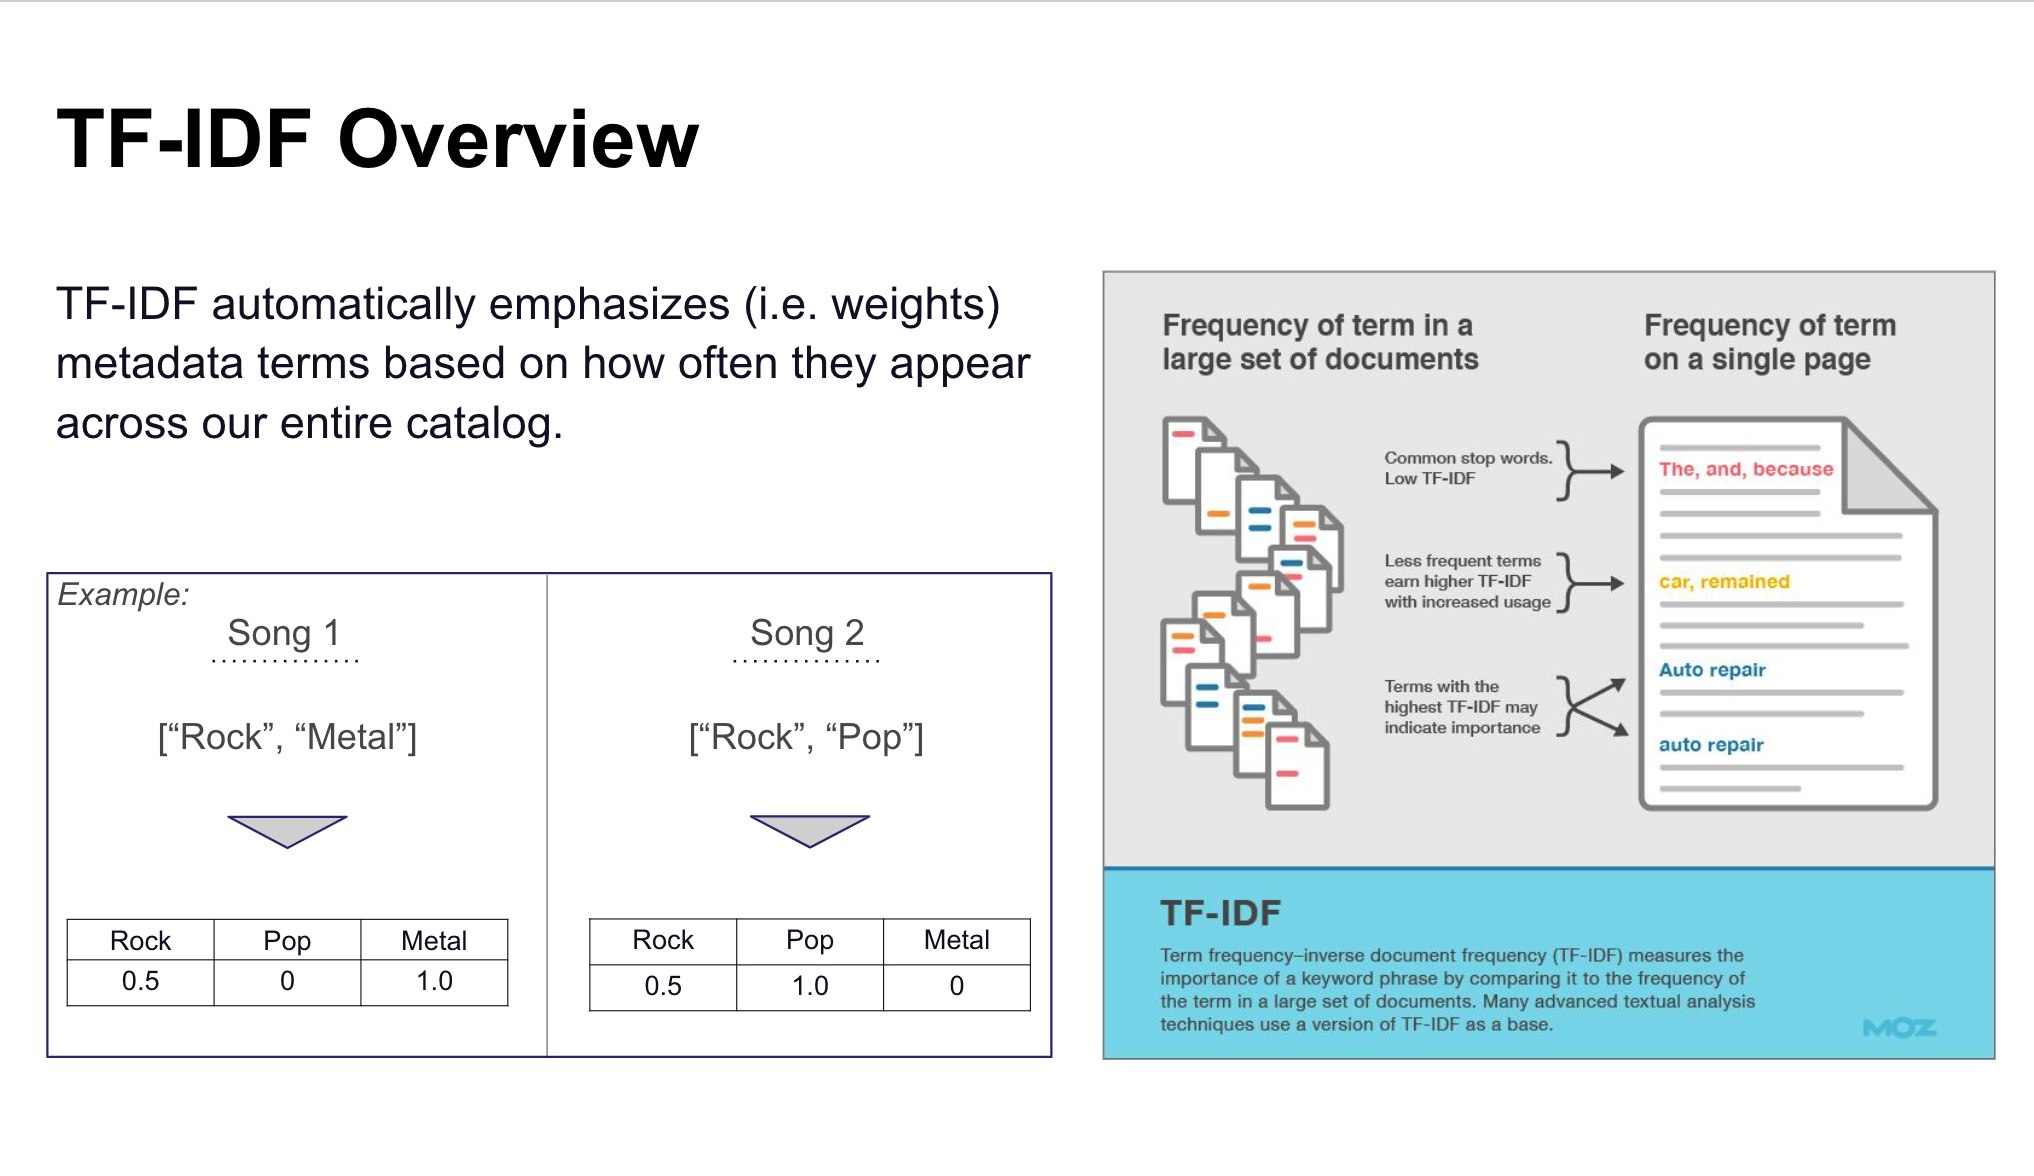

In [42]:
from IPython.display import Image
Image('TF-IDF.png')

In [43]:
#Vectorizacion valores Generos, Año de Lanzamiento y Popularidad asignandole puntajes
#peso asignado a los valores segun que tan frecuentemente aparecen en el conjunto de datos tomado

#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    
    #TfidfVectorizer: Convert a collection of raw documents to a matrix of TF-IDF features.
    tfidf = TfidfVectorizer() #SKLEARN
    #TF-IDF is a popular method. Acronym is “Term Frequency and Inverse Document Frequency”. 
    #TF-IDF is word frequency scores that try to highlight words that are more interesting, 
    #e.g. frequent in a document but not across documents.
    
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [44]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)

In [45]:
complete_feature_set.head()

,genre|21st_century_classical,genre|432hz,genre|_hip_hop,genre|a_cappella,genre|abstract,genre|abstract_beats,genre|abstract_hip_hop,genre|abstract_idm,genre|accordeon,genre|accordion,...,year|2013,year|2014,year|2015,year|2016,year|2017,year|2018,year|2019,year|2020,year|2021,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2ghebdwe2pNXT4eL34T7pW
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,6ra76urfo3pTD050opXTZS
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4FG1uHQAVPsYiXIn3tcGRs
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,2w5L5kQVkSRdduNewYPDA5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3KIuCzckjdeeVuswPo20mC


# 3. Connect to Spotify API

In [170]:
#client id and secret for my application
user = 'asq8vxln0wlr9hwg74vx6z3mr'
client_id = 'ef52f2d7f2194a5e827e29b57625007c'
client_secret= '86274c4d07c8415a968c5fec8bf03ac1'

In [171]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [172]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [173]:
token = util.prompt_for_user_token('asq8vxln0wlr9hwg74vx6z3mr', scope, client_id=client_id, client_secret=client_secret, redirect_uri='http://127.0.0.1:8880/')

In [174]:
sp = spotipy.Spotify(auth=token)

In [175]:
# Se obtienen las playlists del usuario de Spotify autentificado

id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [176]:
# Playlists
id_name

{'Prueba': '3b3pLfbj8p8ATIyM14WpPi',
 'BluesJazzSoul': '4RgwtQGN3qiORBAJY8YmAg',
 'Playlist1': '1599AuhrUlMvNC3XWM4NrF',
 'allTimeClassics': '2co6vXpW30Rk4eb4K3PGNG',
 'ARG': '7ybhLQL70w6KQPyT6wSRYK',
 'New Playlist': '1WC5jUNoWr0Tj697qm2LlR',
 'Ni idea': '1uAwFUFfEVsuzUX8VYh8Nl',
 'Daily Mix 3': '37i9dQZF1E38q3cgbIjQBV',
 '4K': '0c26eG6bjeuJsBf7dmlrmE',
 "Beggin'": '4i4p9lg8O3wvsAaOYiIM6I'}

In [177]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [178]:
id_name

{'Prueba': '3b3pLfbj8p8ATIyM14WpPi',
 'BluesJazzSoul': '4RgwtQGN3qiORBAJY8YmAg',
 'Playlist1': '1599AuhrUlMvNC3XWM4NrF',
 'allTimeClassics': '2co6vXpW30Rk4eb4K3PGNG',
 'ARG': '7ybhLQL70w6KQPyT6wSRYK',
 'New Playlist': '1WC5jUNoWr0Tj697qm2LlR',
 'Ni idea': '1uAwFUFfEVsuzUX8VYh8Nl',
 'Daily Mix 3': '37i9dQZF1E38q3cgbIjQBV',
 '4K': '0c26eG6bjeuJsBf7dmlrmE',
 "Beggin'": '4i4p9lg8O3wvsAaOYiIM6I'}

In [179]:
playlist_BLUES = create_necessary_outputs('Prueba', id_name,spotify_df)
#playlist_chill = create_necessary_outputs('chill',id_name, spotify_df)
#playlist_classical = create_necessary_outputs('Epic Classical',id_name, spotify_df)

In [180]:
# Funcion auxiliar para mostrar las portadas de las canciones

from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [ ]:
# Canciones contenidas en la playlist seleccionada de Spotify y en el dataset
playlist_BLUES

In [ ]:
visualize_songs(playlist_BLUES)

# 4. Generación Vector Playlist del usuario

In [ ]:
from IPython.display import Image
Image('vectorPlaylist.png')

In [ ]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [186]:
complete_feature_set_playlist_vector_BLUES, complete_feature_set_nonplaylist_BLUES = generate_playlist_feature(complete_feature_set, playlist_BLUES, 1.09)

In [187]:
complete_feature_set_playlist_vector_BLUES.shape

(3329,)

# 5. Generate Recommendations

In [ ]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(100)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [189]:
#Obtener recomendaciones
recomendaciones_top20 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_BLUES, complete_feature_set_nonplaylist_BLUES)

In [190]:
recomendaciones_top20.head(100)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red,sim,url
154496,0.000144,['Alex Leavon'],0.638,58000,0.904,0,279l1tEoNRzRJyBrNohqyB,0.000000,8,0.9320,...,0.683,2018,[Alex Leavon],[],[Alex Leavon],Alex LeavonForgotten Empire (FYHYM2018),[progressive_trance],0,0.529259,https://i.scdn.co/image/ab67616d00001e0237089a...
131586,0.000050,['Corti Organ'],0.645,59070,0.839,0,0dLdxQur8TARXfqnhD8ct3,0.000000,5,0.6450,...,0.529,2020,[Corti Organ],[],[Corti Organ],Corti OrganThe Awakening (FYHYM2019),[progressive_trance],0,0.522112,https://i.scdn.co/image/ab67616d00001e02d29531...
148733,0.090800,['Axis'],0.531,199506,0.906,0,6pjOU7BcPw46MIRlf4TG8H,0.000312,1,0.4820,...,0.494,2018,[Axis],[],[Axis],AxisDaylily,[progressive_trance],0,0.521241,https://i.scdn.co/image/901813688dc47b84a8b4ae...
40605,0.000690,['SCHALA'],0.527,225231,0.880,0,48CNqCOXhm3LqpoAumHjZA,0.014700,7,0.8440,...,0.415,2018,[SCHALA],[],[SCHALA],SCHALAAlpha Shear,[progressive_trance],0,0.519421,https://i.scdn.co/image/901813688dc47b84a8b4ae...
149358,0.000539,"['Ashley Wallbridge', 'NASH']",0.595,33000,0.661,0,3TkckpbBGsyzPLlSrbAgy4,0.000147,9,0.2300,...,0.893,2018,"[Ashley Wallbridge, NASH]",[],"[Ashley Wallbridge, NASH]",Ashley WallbridgeGODS (FYHYM2018),"[uplifting_trance, progressive_trance, progres...",0,0.518620,https://i.scdn.co/image/ab67616d00001e0237089a...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130833,0.345000,"['Crosby, Stills & Nash']",0.680,212027,0.574,0,3xYaDMMS4PnZRoi6JYll8w,0.001570,7,0.1400,...,0.749,1977,"[Crosby, Stills & Nash]",[],"[Crosby, Stills & Nash]","Crosby, Stills & NashFair Game","[country_rock, folk, blues_rock, art_rock, psy...",6,0.446752,https://i.scdn.co/image/ab67616d00001e02cc9719...
118127,0.001330,"['Eric Tyrell', 'Denice Perlins', 'Etienne Cor...",0.902,333348,0.844,0,56rnZQSD2C2F0FxqM1EgkQ,0.007520,7,0.6160,...,0.644,2013,"[Eric Tyrell, Denice Perlins, Etienne Corpse, ...",[],"[Eric Tyrell, Denice Perlins, Etienne Corpse, ...",Eric TyrellMamacita Loca - Remix,[],0,0.446296,https://i.scdn.co/image/ab67616d00001e02930ce5...
104567,0.004340,['Gina Star'],0.705,180004,0.973,0,3OJ7oGkx4IKcz1Dv75l37e,0.039400,6,0.3300,...,0.561,2013,[Gina Star],[],[Gina Star],Gina Star1000 Years - BARE Remix,[],0,0.446241,https://i.scdn.co/image/ab67616d00001e02734da8...
79692,0.059400,['Krosfyah (feat. Edwin Yearwood)'],0.626,247467,0.947,0,1MOAOueyuQFsnLSU7dHvwG,0.073300,3,0.0328,...,0.983,2003,[Krosfyah (feat. Edwin Yearwood)],[],[Krosfyah (feat. Edwin Yearwood)],Krosfyah (feat. Edwin Yearwood)Ride It,[],0,0.446220,https://i.scdn.co/image/ab67616d00001e0262d143...


In [ ]:
visualize_songs(classics_top20)